## Possible extra
- Blade angle not dependent on visor angle
- Include other forces
- Check cavitation
- Optimal blade angle
- From specific cutting energy and installed power to theoretical cutting production
- Observe effects of wear on blade




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Arc
from labellines import labelLine, labelLines


class trailing_suction_hopper_dredger(object):

    def __init__(self):
        # General parameters
        self.pressure = 1*10**3 #kpa
        self.water_density = 1025 # kg/m3
        self.sand_density = 2650 # kg/m3
        self.steel_density = 7800 # kg/m3
        self.permeability = 1*10**-4 #m/s
        self.situ_porosity = 0.4 #m/s
        self.internal_friction_angle = 35*np.pi/180 #rad
        self.steel_sand_friction_angle = 26*np.pi/180 #rad
        self.z_coordinate = 30 #m

        # TSHD Parameters
        self.trailing_veloc = 2 #m/s
        self.pipe_diam  = 0.762 #m
        self.line_speed = 6 #m/s

        # Blade parameters
        self.blade_lenght = 0.1 #m
        self.blade_width = 2
        self.blade_angle = 45 * np.pi/180 #rad
        
        # Visor parameters
        self.visor_width = 4 #m
        self.visor_height = 2 #m
        self.visor_weight = 5500 #kg
        self.visor_hor_radius = 2 #m
        self.initial_visor_angle = 20 *np.pi/180 #rad
        self.lower_suction_angle = 45 * np.pi/180 #rad
        
        # Nozzle Parameters
        self.nozzle_diam = 0.0254 #m
        self.jet_exit_veloc = 5 #m/s
        self.nozzles_drag_head = 16 # - 
        
        # Jet parameters
        self.vel_width_ratio = 1
        self.effective_width_power = 0.8
        
        # Model configuration
        self.lower_limit_beta = 5*np.pi/180
        self.upper_limit_beta = 90*np.pi/180
        
        
        # Misc
        self.hi_method = 'Miedema'
        self.cavitating = True
        self.nodes = 5000
        self.accuracy = 10 #Nm

        self._reinitiate()
    

    def _reinitiate(self):
        '''
        If attributes change, this function needs to be called in order to correctly change all dependent attributes
        '''
        
        self.visor_center_of_gravity_hor = 2/3*self.visor_height #m
        self.visor_center_of_gravity_ver = 1/3*self.visor_hor_radius #m
        
        self.power = self.pressure**(2/3)*self.nozzle_diam**2 * self.nozzles_drag_head
        
        self.nozzle_distance = self.visor_width / self.nozzles_drag_head
        
        self.visor_angle_array = np.ones(self.nodes)*self.initial_visor_angle
        
        self.blade_height = self.blade_lenght * np.sin(self.blade_angle)
        
        self.max_hi = self.visor_hor_radius  * np.sin(self.initial_visor_angle) + self.blade_height #m
        

    def _create_vc_data(self):
        '''
        Creates trailing velocity data based on the maximum trailing velocity as defined self.trailing_veloc
        Returns self.vc
        '''
        vc = np.linspace(0.01,self.trailing_veloc,self.nodes)
        self.vc_data = vc
        return vc

    def _calculate_hi_jet(self, vc=None):
        if vc is None:
            vc = self.vc_data
        '''
        Calculates cutting depth
        Requires trailing velocity [Defaults to self.vc_data]
        Checks self.hi_method
        Limits data to self.max_hi
        Returns self.hi_jet
        '''
        if self.hi_method == 'CSB':
            hi = 291 * self.pressure * 0.59*(np.nozzle_diam * 1000)**0.49 * (self.permeability *100)**0.369/1000/self.trailing_veloc
        elif self.hi_method == 'Miedema':
            hi = 2*(self.pressure)**0.5 *self.nozzle_diam**(2/3)*self.permeability**(1/3)/vc
        else:
            print('Not a valid method for calculating hi')
            raise(ValueError, 'self.method is not one of "Miedema", "CBS"')

        hi = np.clip(hi, 0, self.max_hi)
        self.hi_jet = hi
        
        return hi
    
    def _calculate_jet_width(self):
        w_cavity = self.hi_jet * (self.vc_data/self.vel_width_ratio)**self.effective_width_power
        self.jet_width = np.clip(w_cavity, 0, self.nozzle_distance)
        return self.jet_width
        

    def _calculate_draghead_pressure (self, hi=None):
        if hi is None:
            hi = self.hi_jet
        '''
        Calculates draghead pressure
        Requires limited cutting depth [Defaults to self.hi_jet]
        Returns self.draghead_pressure

        '''
        p = hi*self.jet_width*self.vc_data*self.nozzles_drag_head*(1-self.situ_porosity)
        self.draghead_pressure = p
        return p

    def _calculate_Q_pipe(self): 
        '''
        Calculates discharge based on pipe diameter and line speed
        Returns self.q_pipe
        '''
        Q = np.pi/4 * self.pipe_diam**2 * self.line_speed 
        self.q_pipe = Q
        return Q

    def _calculate_constant_volume_system(self, pressure=None):
        if pressure is None:
            pressure = self.draghead_pressure
        ''' 
        Calculates the Constant Volume System
        Requires pressure in the draghead [Defaults to self.draghead_pressure]
        Returns self.cvs

        '''
        cvs = pressure/self.q_pipe
        self.cvs = cvs
        return cvs
        #
    def _calculate_mixture_density(self, cvs=None):
        if cvs is None:
            cvs = self.cvs
        '''
        Calculates the density of the mixture
        Requires constant volume system self.cvs
        Returns self.mixture_density
        '''
        dens = (1-cvs)*self.water_density/1000+cvs*self.sand_density/1000
        self.mixture_density = dens
        return dens
#
    def calculate_jet_production(self):
        self._create_vc_data()
        self._calculate_hi_jet()
        self._calculate_jet_width()
        self._calculate_draghead_pressure()
        self._calculate_Q_pipe()
        self._calculate_constant_volume_system()
        self._calculate_mixture_density()

    def create_jet_production_data(self):
        self.calculate_jet_production()
        df = pd.DataFrame(index=np.arange(self.nodes))
        df['vc [m/s]'] = self.vc_data
        df['hi_jet'] = self.hi_jet
        df['jet p_draghead'] = self.draghead_pressure
        df['Q_pipe'] = self.q_pipe
        df['jet cvs'] = self.cvs
        df['jet mixture density'] = self.mixture_density
        df = df.round(3)
        self.production_df = df
        return df

    
    ##############
    ### FORCES ###
    ##############
    # - F impuls mixture V
    # - F vacuum V
    # - F sled visor V
    # - F gravity V
    # - F cutting V


    #Define a function 'Impulseforce1()' due to redirection of the sand mixture
    def _calculate_impulseforce_sand_redirection(self):
        '''
        NOT IMPLEMENTED IN MOMENT BALANCE
        
        Calculates impulseforce as a result of the sand water mixture redirection in the visor
        Requires self.mixture_density
        Returns self.impulsforce_sand_redirection, impulsvertical, impulshorizontal
        '''
        #self.sand_water_situ_density = self.sand_density*(1-n)+self.water_density*self.situ_porosity
        
        beta_v = np.pi-self.lower_suction_angle
        self.pipe_area = np.pi/4*self.pipe_diam**2
        impulsehorizontal1 = (self.mixture_density*self.pipe_diam*self.line_speed**2*(1-np.cos(beta_v)))**2                 #squared
        impulsevertical1 = (self.mixture_density*self.pipe_diam*self.line_speed**2*(np.sin(beta_v)))**2                     #squared
        impulsetotal1 = np.sqrt(impulsehorizontal1+impulsevertical1)
        self.impulsforce_sand_redirection = [impulsehorizontal1, impulsevertical1]
        return impulsetotal1, impulsevertical1, impulsehorizontal1

    #Define a function 'Vacuumforce'
    def _calculate_vacuumforce(self):
        '''
        NOT IMPLEMENTED IN MOMENT BALANCE
        
        Calculates vacuumforce as result of negative pressure at the draghead mouth
        Requires self.mixture_density
        Returns self.vacuumforce 

        Vacuumforce ontbinding?
        '''
        vacuumforce = C*0.5*self.mixture_density*self.line_speed**2*self.visor_area
        self.vacuumforce = vacuumforce
        return vacuumforce

    def _calculate_gravity_force(self):
        '''
        Calculates self weight forcing based on self.visor_weight
        Returns self.gravity_force
        '''
        relative_density = (self.steel_density - self.water_density)/self.steel_density
        self.gravity_force = self.visor_weight * relative_density * 9.81
        return self.gravity_force


    '''
    Calculating cutting forces:
    - First we determine the horizontal non-dimensional forces d1 and c1
    - Then we calculate the cutting forces on the blade
    - We find the angle for which a balance of moments is found (So far only for Fgravity & Fcutting)
    - We calculate the cutting forces again and iterate
    '''
    
    def _hi_cutting_formulae(self, visor_angle, hi_jet):
        total_height = np.sin(visor_angle) * self.visor_hor_radius + self.blade_height
        hi_cutting = np.clip(total_height - hi_jet, 0, self.blade_height)
        return hi_cutting
    
    def _calculate_hi_cutting(self, cur_index=None):
        '''
        Calculates cutting depth based on the visor angle, the visor length and the hi_jet
        Requires hi_jet
        '''
        if cur_index == None:
            visor_angle = self.initial_visor_angle
            hi_jet = self.hi_jet
            self.hi_cutting = self._hi_cutting_formulae(visor_angle, hi_jet)

        else:
            visor_angle = self.visor_angle_array[cur_index]
            hi_jet = self.hi_jet[cur_index]
            self.hi_cutting[cur_index] = self._hi_cutting_formulae(visor_angle, hi_jet)
            
        return self.hi_cutting
    
    def _shear_angle_formulae(self, hi_cutting):
        beta = 1 - 1/6*self.blade_angle -2/7*(self.internal_friction_angle+self.steel_sand_friction_angle)-0.057 *self.blade_height/hi_cutting
        beta = np.clip(beta, self.lower_limit_beta, self.upper_limit_beta)
        return beta
        
    def _calculate_shear_angle(self, cur_index=None):
        '''
        Calculates the shear angle of the soil based on the hi cutting, blade angle and friction angles
        Requires hi_cutting
        Returns shear angle based on empirical relationship
        '''
        
        if cur_index==None:
            hi_cutting = self.hi_cutting
            self.shear_angle = self._shear_angle_formulae(hi_cutting)
        else:
            hi_cutting = self.hi_cutting[cur_index]
            self.shear_angle[cur_index] = self._shear_angle_formulae(hi_cutting)
            
        #self.shear_angle1 = 61.29*np.pi/180 + 0.345 * self.blade_height / hi_cutting - 0.3068 * self.blade_angle- 0.4736*self.steel_sand_friction_angle - 0.248 * self.internal_friction_angle
        #self.shear_angle1 = np.clip(self.shear_angle1, self.lower_limit_beta, self.upper_limit_beta)
        
        return self.shear_angle
    
    def _nondimensional_force_formulae(self, hi, alpha, beta, phi, delta):
        if hi > 0:

               # Horizontal 
            part_1 = np.sin(phi)/np.sin(beta) + self.blade_height/hi*np.sin(min(alpha + beta + phi, np.pi))/np.sin(alpha)

            part_2 = np.sin(alpha + delta)/np.sin(min(phi + beta + alpha + delta, np.pi))
            part_3 = self.blade_height / hi *np.sin(alpha)/np.sin(alpha)
            d1 = np.clip(part_1*part_2 - part_3, 0, None)

            # vertical 
            part_2 = np.cos(alpha + delta)/np.sin(min(phi + beta + alpha + delta, np.pi))
            part_3 = self.blade_height / hi *np.cos(alpha)/np.sin(alpha)
            d2 = np.clip(part_1*part_2 - part_3, 0, None)

        else: 
            d1 = 0
            d2 = 0
            
        return d1, d2
                    
            

    def _calculate_nondimensional_forces(self, cur_index=None):

        '''
        Calculates horizontal and vertical dimensionless cutting forces d1 and d2
        Requires self.shear_angle
        Returns [self.d1, self.d2]
        '''
        alpha = self.blade_angle
        delta = self.steel_sand_friction_angle
        phi = self.internal_friction_angle
        beta_array = self.shear_angle 

        if cur_index==None:
            hi_cutting = self.hi_cutting

            self.d1 = np.zeros(self.nodes)
            self.d2 = np.zeros(self.nodes)

            for k, hi in enumerate(hi_cutting):
                beta = beta_array[k]
                d1, d2 = self._nondimensional_force_formulae(hi, alpha, beta, phi, delta)
                self.d1[k] = d1 
                self.d2[k] = d2
                
        else:
            hi_cutting = self.hi_cutting[cur_index]
            beta = beta_array[cur_index]
            d1, d2 = self._nondimensional_force_formulae(hi_cutting, alpha, beta, phi, delta)
            self.d1[cur_index] = d1
            self.d2[cur_index] = d2
            

        return self.d1, self.d2
    
    
    def _check_cavitation(self, hi=None):
        '''
        NOT IMPLEMENTED 
        
        What is km? And how can it be determined?
        Is cutting velocity the same as trailing velocity?
        Why z+10? Because of the cavitation limit of 10 m.w.c.?
        For the first cavitating assumptions uses a single boolean value for self.cavitating, 
        still need to change for a full check per velocity.
        '''
        
        # FOR INITIAL ASSUMPTION OF CAVITATING CUTTING
        self.cavitating = True
        return True
        
        # Actual check NOT IN USE
        if hi == None:
            hi = self.hi_cutting
        if trailing_velocity == None:
            trailing_velocity = self.trailing_veloc
            
        cavitation_velocity = self.d1 / self.d2 * (self.z_coordinate+10)/hi * km/self.dilatation_ratio
        self.cavitating = trailing_velocity > cavitation_velocity

    def _cutting_force_formulae(self, d1, d2, hi_cutting):
        fh = d1 * self.water_density * 9.81 * (self.z_coordinate + 10) * hi_cutting * self.blade_width
        fv = d2 * self.water_density * 9.81 * (self.z_coordinate + 10) * hi_cutting * self.blade_width
        return fh, fv
    
    def _calculate_cutting_force_on_blade(self, cur_index=None):
        '''
        Calculates hor. and vert. cutting forces on blade based on the non dimensional cutting force, cutting depth and contextual parameters
        Requires self.hi_cutting self.d1 self.d2
        Returns self.horizontal_cutting_force, self.vertical_cutting_force
        '''
        if cur_index == None:
            hi_cutting = self.hi_cutting
            d1 = self.d1
            d2 = self.d2
            if self.cavitating:
                self.horizontal_cutting_force, self.vertical_cutting_force = self._cutting_force_formulae(d1, d2, hi_cutting)
            
            else:
                print('Non-cavitating has not been implemented yet!')
                pass
            
        else:
            hi_cutting = self.hi_cutting[cur_index]
            d1 = self.d1[cur_index]
            d2 = self.d2[cur_index]
            self.horizontal_cutting_force[cur_index], self.vertical_cutting_force[cur_index] = self._cutting_force_formulae(d1, d2, hi_cutting)
        return self.horizontal_cutting_force, self.vertical_cutting_force

    
    ###############
    ### MOMENTS ###
    ###############

    def _calculate_arms(self, cur_index=None):
        if cur_index == None:
            visor_angle = self.visor_angle_array
            self.hor_cutting_force_arm = self.visor_hor_radius*np.sin(visor_angle)+self.blade_height       
            self.gravity_force_arm = self.visor_center_of_gravity_hor*np.cos(visor_angle)+self.visor_center_of_gravity_ver*np.sin(visor_angle)

        else:
            visor_angle = self.visor_angle_array[cur_index]
            self.hor_cutting_force_arm[cur_index] = self.visor_hor_radius*np.sin(visor_angle)+self.blade_height        
            self.gravity_force_arm[cur_index] = self.visor_center_of_gravity_hor*np.cos(visor_angle)+self.visor_center_of_gravity_ver*np.sin(visor_angle)

        return self.hor_cutting_force_arm, self.gravity_force_arm 
    
    
    def _calculate_moments(self):
        '''
        Calculates the moments induced by forces, as of yet including; gravity force, horizontal cutting force
        Requires self.gravity_force_arm self.cutting_force_arm self.horizontal_cutting_force self.gravity_force
        Returns balance of moments
        '''
        self.hor_cutting_moment = - self.hor_cutting_force_arm * self.horizontal_cutting_force #clockwise
        self.gravity_moment = self.gravity_force_arm * self.gravity_force # counter-clockwise
        
        self.moment_balance = self.hor_cutting_moment + self.gravity_moment
        return self.moment_balance
    
    
        
    def calculate_forces_and_moments(self, cur_index=None):
        ## Forces
        # Gravity
        self._calculate_gravity_force()
        
        #Cutting
        self._calculate_hi_cutting(cur_index)
        self._calculate_shear_angle(cur_index)
        self._calculate_nondimensional_forces(cur_index)
        self._check_cavitation()
        self._calculate_cutting_force_on_blade(cur_index)
        
        ## Moments
        # Arms
        self._calculate_arms(cur_index)
        
        # Balance
        self._calculate_moments()
        
    
    def _calculate_angle_from_momentbalance(self,cur_index):
        Fc = self.horizontal_cutting_force[cur_index]
        Fg = self.gravity_force
        Gy = self.visor_center_of_gravity_ver
        Gx = self.visor_center_of_gravity_hor
        Rv = self.visor_hor_radius
        
        err = 1
        prev_angle = self.visor_angle_array[cur_index]
        balance_angle = None
        
        while err > 0.001:
            balance_angle = np.arctan2(-self.blade_height/np.cos(prev_angle) * Fc + Gx*Fg, -Fg*Gy + Fc*Rv)
            prev_angle = balance_angle
            err = abs(prev_angle - balance_angle)
        
        return balance_angle
                
    def iterate_angles(self, log=False):
        
        # get first value where momentbalance is not positive
        kmin = np.where(self.moment_balance < -self.accuracy, self.moment_balance, -np.inf).argmax()
        self.kmin = kmin
        # set up dataframe to save iterations
        self.iter_df = pd.DataFrame(index=np.arange(self.nodes - kmin), columns=['iters'])
        
        # Loop over all rows where moment balance is not positive
        for cur_index in range(kmin, self.nodes):
            iters = []
            iters_moment = []
            
            if log:
                print('\n')
                print(cur_index)
                
            
            positive_moment_allowed = False
#             upbound = min(self.initial_visor_angle, np.arcsin(self.hi_jet[cur_index]/self.visor_hor_radius))
            upbound = self.initial_visor_angle
            lowbound = -np.arcsin(self.blade_height/self.visor_hor_radius)  
        
            blade_bound = np.arcsin(self.hi_jet[cur_index]/self.visor_hor_radius)
            # bisection method untill momentbalance is approx. zero
            if log:
                print('| Initial angle | ', 'Balance angle | ', 'New angle | ', 'Resulting moment | ')
            while True:

                # calculating new balance with bisect angle based on old angle and "balance angle"
                old_angle = self.visor_angle_array[cur_index]
                balance_angle = self._calculate_angle_from_momentbalance(cur_index)
                
                if balance_angle > blade_bound and self.hi_cutting[cur_index] >= self.blade_height:
                    positive_moment_allowed = True
                    if log:
                        print('Positive moment allowed')
                balance_angle = np.clip(balance_angle, lowbound, min(upbound, blade_bound))
                
                # saving iteration for visualisation
                iters.append(self.visor_angle_array[cur_index])
                
                # Bisection method
                new_angle = (old_angle+balance_angle)/2
                self.visor_angle_array[cur_index] = new_angle

                self.calculate_forces_and_moments(cur_index)
                e = self.moment_balance[cur_index]

                if self.moment_balance[cur_index] > 0:
                    lowbound = new_angle
                    
                # Save moments iteration for visualisation
                iters_moment.append(self.moment_balance[cur_index])
                              
                if log:
                    print(old_angle*180/np.pi, balance_angle*180/np.pi, self.visor_angle_array[cur_index]*180/np.pi, self.moment_balance[cur_index])
                
                
                # if accuracy is reached break and continue with next row (velocity)
                if abs(e) < self.accuracy or (positive_moment_allowed == True and e > 0):
                    self.visor_angle_array[cur_index:] = new_angle
                    self.iter_df.iloc[cur_index-kmin] = [np.array([[iters], [iters_moment]])]
                    break
        
        return self.iter_df
    
    def plot_iterations(self, N=15):
        fig1,[ax1, ax2] = plt.subplots(1,2, figsize=(20,10))
        for q in np.arange(0,self.iter_df.size, round(self.iter_df.size/N)):
            angle = self.iter_df['iters'][q][0][0]*180/np.pi
            moment = self.iter_df['iters'][q][1][0]/1000
            n = np.arange(len(angle))
            ax1.plot(n, angle, label=f'vc = {round(self.vc_data[q],2)}')
            ax2.plot(n, moment, label=f'vc = {round(self.vc_data[q],2)}')
            ax1.legend()
            ax2.legend()
            
        return plt.show()
    
    
    def create_dataframe(self):
        df = pd.DataFrame(index=np.arange(self.nodes), columns=['vc [m/s]', 'hi_jet [m]', 'hi_cut [m]', 'beta [rad]', 'beta [deg]', 'R_g [m]', 'R_ch [m]','d1 [-]', 'd2 [-]', 'Fh [kN]','Fv [kN]', 'Fg [kN]', 'M_res [kNm]'])
        df['vc [m/s]'] = self.vc_data
        df['hi_jet [m]'] = self.hi_jet
        df['hi_cut [m]'] = self.hi_cutting
        df['beta [rad]'] = self.shear_angle
        df['beta [deg]'] = df['beta [rad]']*180/np.pi
        df['R_g [m]'] = self.gravity_force_arm
        df['R_ch [m]'] = self.hor_cutting_force_arm
        df['d1 [-]'] = self.d1
        df['d2 [-]'] = self.d2
        df['Fh [kN]'] = self.horizontal_cutting_force / 1000
        df['Fv [kN]'] = self.vertical_cutting_force / 1000
        df['Fg [kN]'] = self.gravity_force*np.ones(self.nodes) / 1000
        df['M_res [kNm]'] = self.moment_balance / 1000
        df = df.round(3)
        self.df = df
        
        self.breakpoint = np.argmin(np.where(self.df['hi_cut [m]'] > self.blade_height, self.df['hi_cut [m]'], np.inf))

        return self.df
    
    
    def plot_model(self, cur_index=None):
        if cur_index == None:
            visor_angle = self.initial_visor_angle
        else:
            visor_angle = self.visor_angle_array[cur_index]

        # Create data points
        pipe_arm_lenght = self.z_coordinate/self.lower_suction_angle
        pipe_arm = [[0,np.cos(self.lower_suction_angle)*pipe_arm_lenght],[0,self.z_coordinate]]

        visor = [[pipe_arm[0][1], pipe_arm[0][1]+np.cos(visor_angle)*self.visor_hor_radius],[pipe_arm[1][1], pipe_arm[1][1]+np.sin(visor_angle)*self.visor_hor_radius]]

        blade = [[visor[0][1], visor[0][1]-np.cos(self.blade_angle)*self.blade_lenght], [visor[1][1], visor[1][1]+self.blade_height]]

        # Define plot and zoom
        fig,axes = plt.subplots(1,2)
        fig.set_size_inches(20, 10)

        ax = axes[0]
        axz = axes[1]

        ax.set_ylim(self.z_coordinate+5, -5)
        ax.set_xlim(pipe_arm[0][1]+5, -5) 
        axz.set_ylim(self.z_coordinate+1.5, self.z_coordinate-1.5)
        axz.set_xlim(pipe_arm[0][1]+self.visor_hor_radius*1.1, pipe_arm[0][1]-1) 
        ax.set_aspect('equal')
        axz.set_aspect('equal')

            
        origin = [np.cos(self.lower_suction_angle)*pipe_arm_lenght, self.z_coordinate]
        
        arc = Arc(origin, 0.7*self.visor_hor_radius, 0.4*self.visor_hor_radius, 0, 0, visor_angle*180/np.pi, color='black', lw=1)
        axz.add_patch(arc)        

        #plot blade
        ax.plot(blade[0], blade[1], label='Blade')
        axz.plot(blade[0], blade[1], label='Blade')

        #plot visor
        ax.plot(visor[0], visor[1], label='Visor')
        axz.plot(visor[0], visor[1], label='Visor')

        # plot arm
        ax.plot(pipe_arm[0],pipe_arm[1], label='Lower suction pipe}')
        axz.plot(pipe_arm[0], pipe_arm[1], label='Lower suction pipe')

        # Plot waterline and bottom
        ax.axhline(self.z_coordinate, color='brown', ls='dashed', label='bottom')
        axz.axhline(self.z_coordinate, color='brown', ls='dashed', label='bottom')    
        ax.axhline(0, color='blue', ls='dashed', label='sealevel')
        axz.axhline(0, color='blue', ls='dashed', label='sealevel')

        # Plot jet and cutting depth

        if cur_index:            
            ax.axhline(self.hi_jet[cur_index]+self.z_coordinate+self.hi_cutting[cur_index], color='green', ls='dashed', label='cutting depth')
            ax.axhline(self.hi_jet[cur_index]+self.z_coordinate, color='orange',ls='dashed', label='jet depth')
            
            axz.axhline(self.hi_jet[cur_index]+self.z_coordinate+self.hi_cutting[cur_index], color='green',ls='dashed', label='cutting depth')    
            axz.axhline(self.hi_jet[cur_index]+self.z_coordinate, color='orange', ls='dashed', label='jet depth')
        
        axz.text(np.cos(self.lower_suction_angle)*pipe_arm_lenght+0.5*self.visor_hor_radius, self.z_coordinate+0.05*self.visor_hor_radius, str(round(visor_angle*180/np.pi,2))+u"\u00b0")
            
        ax.legend()
        ax.set_title(f'Velocity = {self.vc_data[cur_index]}')
        axz.legend()
        axz.set_title(f'Velocity = {self.vc_data[cur_index]}')

                
        return plt.show()
    
    
    def create_total_production_data(self):
        self.production_df['hi_cut'] = self.df['hi_cut [m]']
        self.production_df['hi_total [m]'] = self.df['hi_jet [m]'] + self.df['hi_cut [m]']
        self.production_df['total p_draghead'] = self._calculate_draghead_pressure(hi = self.production_df['hi_total [m]'])
        self._calculate_Q_pipe()
        self.production_df['total cvs'] = self._calculate_constant_volume_system(pressure=self.production_df['total p_draghead'])
        self.production_df['total mixture density'] = self._calculate_mixture_density(cvs = self.production_df['total cvs'])
        
        return self.production_df
    
    
    def plot_production_data(self, simple=False, extra_label=None, ax=None):
        if simple:
            if ax == None:
                fig, ax = plt.subplots(figsize=(10,10))
            line = self.production_df.iloc[:,[0, -1]].plot(x='vc [m/s]', ax=ax)
            label = self.production_df.columns[-1] + ' - ' + extra_label
            return line, label

        else:
            fig,[[ax1, ax2],[ax3, ax4]] = plt.subplots(2,2, figsize=(20,20))

            self.production_df.iloc[:,[0, -1, 5]].plot(x='vc [m/s]', ax=ax1)
            ax1.axvline(self.production_df['vc [m/s]'][self.breakpoint], color='red', ls='dashdot', lw=0.5, label='Velocity where hi_cut > hb')
            ax1.legend()

            self.production_df.iloc[:,[0, -4, -5, 1]].plot(x='vc [m/s]', ax=ax2)
            ax2.axvline(self.production_df['vc [m/s]'][self.breakpoint], color='red', ls='dashdot', lw=0.5, label='Velocity where hi_cut > hb')
            ax2.legend()

            self.production_df.iloc[:,[0, -3, 2]].plot(x='vc [m/s]', ax=ax3)
            ax3.axvline(self.production_df['vc [m/s]'][self.breakpoint], color='red', ls='dashdot', lw=0.5, label='Velocity where hi_cut > hb')
            ax3.legend()

            self.production_df.iloc[:,[0, -2, 4]].plot(x='vc [m/s]', ax=ax4)
            ax4.axvline(self.production_df['vc [m/s]'][self.breakpoint], color='red', ls='dashdot', lw=0.5, label='Velocity where hi_cut > hb')
            ax4.legend()
        
            return plt.show()
    
    
    def run_main_iteration(self, log=False, plot=False):
        tshd._reinitiate()
        tshd.create_jet_production_data()
        tshd.calculate_forces_and_moments()
        tshd.iterate_angles(log=log)
        if plot:
            tshd.plot_iterations()
        df = tshd.create_dataframe()
        return df
            
    def model_comparison(self, parameter, p_range, N=5, log=False):

        if not hasattr(self, parameter):
            raise(AttributeError,'This parameter does not exist. Be careful to select a parameter and a range that may be realistically compared.')
        if parameter in ['blade_angle', 'initial_visor_angle', 'lower_suction_angle', 'internal_friction_angle', 'steel_sand_friction_angle']:
            if max(abs(np.array(p_range))) > np.pi:
                print('Warning! Angles have to be given in radians. It seems this angle is > 180 degrees. Check ya self before ya reck ya self.')
                
                
        fig, ax = plt.subplots(figsize=(10,10))
        labels = []
        for p in np.linspace(p_range[0], p_range[1], N):
            if parameter in ['blade_angle', 'initial_visor_angle', 'lower_suction_angle', 'internal_friction_angle', 'steel_sand_friction_angle']:
                p_string = p*180/np.pi
            else:
                p_string = p
            print(f'Running new iteration for {parameter} = {p_string}')
            
            setattr(self, parameter, p)
            self.run_main_iteration(log=log)
            self.create_total_production_data()
            
            extra_label = f'{parameter} = {round(p_string,2)}'
            line, label = self.plot_production_data(simple=True, extra_label=extra_label, ax=ax)
            labels.append(label)
        
        handles, wrong_labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels)
        return plt.show()

            
        

# List of symbols

## General parameters
$$p = \mbox{Reference pressure}$$
$$\rho_w = \mbox{Water density}$$
$$\rho_{sand} = \mbox{Sand density}$$
$$\rho_{steel} = \mbox{Water density}$$
$$ k = \mbox{Permeability}$$
$$ \eta = \mbox{In-situ Porosity}$$
$$ \phi = \mbox{Angle of Internal Friction}$$
$$ \delta = \mbox{Steel-Sand Friction Angle}$$
$$ z = \mbox{Waterdepth}$$


## TSHD Parameters
$$ v_c = \mbox{Trailing Velocity / Cutting Velocity}$$
$$ D_{pipe} = \mbox{Pipe Diameter}$$
$$ v_l = \mbox{Linespeed}$$

## Blade Parameters
$$ h_b = \mbox{Blade Height}$$
$$ w_b = \mbox{Blade Width}$$
$$ l_b = \mbox{Blade Lenght}$$
$$ \alpha = \mbox{Blade Angle}$$

## Visor Parameters
$$ w_v = \mbox{Visor Width}$$
$$ R_v = \mbox{Visor Radius}$$
$$ \theta = \mbox{Visor Angle}$$
$$ G_{x,v} = \mbox{Center of Gravity in x-direction, Visor}$$
$$ G_{y,v} = \mbox{Center of Gravity in y-direction, Visor}$$
$$ \omega = \mbox{Angle of Lower Suction Pipe}$$

## Jet Parameters
$$ D_{nozzle} = \mbox{Nozzle diameter}$$
$$ v_{jet} = \mbox{Jet Exit Velocity}$$
$$ N_{nozzles} = \mbox{Number of nozzles}$$
$$ w_{jet} = \mbox{Jet Cavity Width}$$
$$ VW_{ratio} = \mbox{Velocity Width Ratio}$$
$$ \beta_{jet} = \mbox{Power of Effective Width Trailing Speed Dependency}$$


## Forces & Moments
$$ d_1 = \mbox{Non-dimensional Horizontal Cutting Force}$$
$$ d_2 = \mbox{Non-dimensional Vertical Cutting Force}$$
$$ F_{c,hor} = \mbox{Horizontal Cutting Force}$$
$$ F_{c,ver} = \mbox{Vertical Cutting Force}$$
$$ F_g = \mbox{Gravity Force}$$
$$ R_{Fc,h} = \mbox{Arm Horizontal Cutting Force}$$
$$ R_{Fg} = \mbox{Arm Gravity Force}$$

$$ M_{res} = \mbox{Resulting Moment}$$



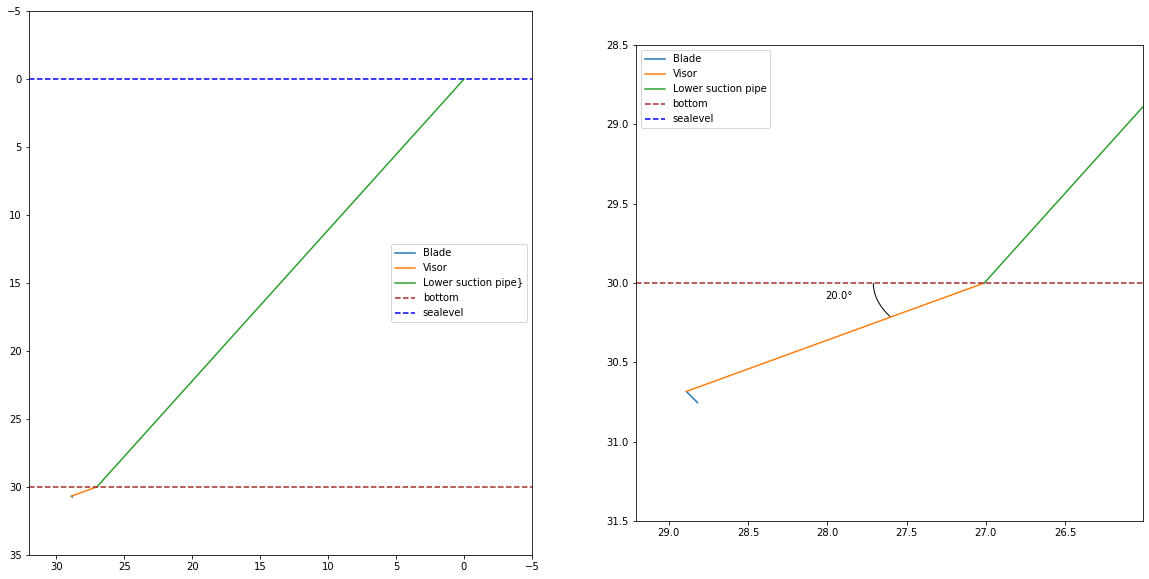

In [3]:
tshd = trailing_suction_hopper_dredger()
tshd.plot_model()

# Jet production

## Formulae
##  Jet diepte 
For the determination of the jet layer thickness there are two methods. Namely the CSB (Combinatie Speurwerk Baggertechniek) method and the method by S. Miedema. Both methods are used to compare and are shown here below. 

\begin{equation}
    h_{i,jet,CSB}= \frac{291*p*0.59*(D_{nozzle}*1000)^{0.49}*k*100^{\frac{0.369}{1000}}}{v_{c}}
\end{equation}

\begin{equation}
    h_{i,jet,Miedema}= 2 * \frac{(\Delta p_j)^\frac{1}{2}* D^\frac{2}{3} * k_{i}^\frac{1}{3}}{v_{c}} 
\end{equation}

where:

$$p_{j} = \mbox{pressure at the jet}$$
$$D_{nozzle} = \mbox{width of the nozzles}$$
$$k = \mbox{permeability of the sand}$$

Apparently, the production of one nozzle is a constant and not depending on the trailing speed, given the assumption
and simplification that β and v1 are both about unity.

uitleg:
$H_{i,jet}$ must be limited because at low speeds. 


##  Draghead pressure 

The following equation is used for the calculation of the draghead pressure. 
\begin{equation}
    p_{draghead}=h_{i}*w_{jet}*v_{c}*nozzles*(1-n)
\end{equation}
where:

$$h_{i} = \mbox{cut layer thickness[m]}$$
$$v_{c} = \mbox{trailing speed [m/s]}$$
$$nozzles = \mbox{number of nozzles[-]}$$
$$n = \mbox{porosity}$$
$$ w_{jet} = \mbox{Jet Cavity Width}$$
$$ VW_{ratio} = \mbox{Velocity Width Ratio}$$
$$ \beta_{jet} = \mbox{Power of Effective Width Trailing Speed Dependency}$$

With:

\begin{equation}
    w_{jet} = h_{i}*(v_{c}/VW_{ratio}^{\beta_jet}
\end{equation}

It can be observed that the pressure of the draghead is dependent on the trailing speed. The layer thickness has a limit value and becomes smaller as the trailing speed increases. w is limited aswell because the cavitation spray by the the nozzles is overlapping each other as shown in the picture below. Based on this width the desing of the draghead is made and the distance between the nozzles will be based on the cavitation width. 


![Cavitation Depth](cavitation_depth)


## Volumestroom $Q_{pipe}$

\begin{equation}
    Q_{pipe} =\frac{\pi}{4} * D_{pipe}^2 * V_{I} 
\end{equation}
where:

$$ Q_{pipe} = \mbox{Volumetric flow rate [m^3/s]} $$
$$ D_{pipe} = \mbox{Diameter pipe [m]} $$
$$ V_{I} = \mbox{Flow speed in pipe [m/s]} $$

uitleg:

$Q_{pipe}$ is the volumetric flow rate  of material that flows true suction the pipe which consists of a mixture of Sand and water. 



## Constant Volume System 

Spatial Volumetric concentration 
\begin{equation}
    C_{vs} =\frac{p_{draghead}}{D_{pipe}}
\end{equation}

where:

$$C_{vs} = \mbox{spatial Volumetric concentration[-]}$$
$$p_{draghead} = \mbox{pressure in the draghead at seafloor[N/m^2]} $$
$$D_{pipe} = \mbox{Diameter pipe [m]}$$

uitleg:


## Mixture density

\begin{equation}
    \rho_{mixture}=(1-cvs)*\frac{\rho_{water}}{1000}+cvs*\frac{\rho_{sand}}{1000}
\end{equation}

Where:
$$\rho_{water} = \mbox{Density of water [kg/m^3]}$$
$$\rho_{sand} = \mbox{Density of sand [kg/m^3]}$$
$$\rho_{mixture} = \mbox{Density of material sucked up [kg/m^3]}$$

With this formula the density of the material in the pipe is calculated, it exist of water and sand in this situation.










 

# Iterating the visor angle

With the above formulae one can determine:
- The cutting depth and force as a result of the visor angle
- The visor angle that is prescribed by the moment balance 

In order to obtain a cutting depth and visor angle which satisfies the moment balance at a certain trailing velocity 

![Iteration Scheme](iteration_scheme2.jpeg "Iteration scheme to determine the angle at which there is a balance of moments")

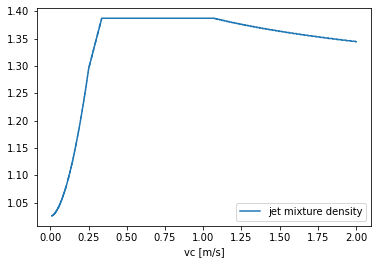

In [4]:
tshd.create_jet_production_data()
tshd.production_df.iloc[:,[0,-1]].plot(x='vc [m/s]')
plt.show()


# Cutting production

## Gravity force

To determine the gravity force of the visor when it is submerged under water, there has to be accounted for the density of the (sea)water. A relative density has to be calculated with the following formula:

$$
\rho_{relative} = (\rho_{steel} - \rho_{water})/\rho_{steel}
$$

The gravity force of the submerged visor can be computed by multiplying the weight of the visor with the relative density and the gravitational acceleration as the equation below describes.

$$
F_{g} = m_{visor}*\rho_{relative}*g
$$

The gravity force of the visor causes a (+/-) moment on the visor hinge. It's operating point is located at the horizontal and vertical positions $G_{x,v}$ and $G_{y,v}$ with respect to the visor hinge.

## Shear angle

The blades/teeth of the visor exert a force on the sand which causes the sand particles to move, changing its initial packed grain structure. Due to this movement the volume of the excavated sand, positioned on the blades, increases because little space is created between the still closely packed sand. The space between the particles is then filled with water and pressure differences occur between the pores, resulting in an increase of the grain stresses and also higher cutting forces. This phenomenon is called dilatancy. An increase of the cutting velocity causes a rise of the pressures in the pores. Eventually this pressure can reach the saturated water vapour pressure and cavitation will occur. For the determination of the shear angle a cavitating process is considered. As a result there has been assumed that there are no pressure difference in the pores and therefore the streamlines have not ot be accounted for. Based on the minimum energy principle an approximation of the shear angle can be determined numerically. This value is depending on the blade angle, the layer thickness ratio, the angle of internal friction and the steel-sand friction angle. The equation is stated below.  

$$
\beta = 1 - \frac{1}{6}\cdot\alpha - \frac{2}{7}\cdot(\phi + \delta) - 0.057\cdot\frac{h_{b}}{h_{i}}
$$

## Dimensionless cutting force

After the shear angle is determined by the minimal energy principle, the dimensionless cutting forces in the horizontal and vertical direction can be calculated, still assuming that only cavitation occurs. For the horizontal and vertical component of the dimensionless cutting force the following equations are used respectively.

$$
d_{1} = \frac{(\frac{sin(\phi)}{sin(\beta)}+\frac{h_{b} \cdot sin(\alpha + \beta + \phi)}{sin(\alpha)}) \cdot sin(\alpha + \beta)}{sin(\alpha + \beta + \delta + \phi)}-\frac{h_{b} \cdot sin(\alpha)} {h_{i} \cdot sin(\alpha)}
$$

and 

$$
d_{2} = \frac{(\frac{sin(\phi)}{sin(\beta)}+\frac{h_{b} \cdot sin(\alpha + \beta + \phi)}{sin(\alpha)}) \cdot sin(\alpha + \beta)}{sin(\alpha + \beta + \delta + \phi)}-\frac{h_{b} \cdot cos(\alpha)} {h_{i} \cdot sin(\alpha)}
$$

## Cutting force

For the calculation of the cutting forces it is assumed that inertia, gravitation, adhesion and cohesion can be neglected. By using the horizontal and vertical dimensionless cutting forces, the real horizontal and vertical cutting forces can be determined by using the equations below. 

$$
F_{c,hor} = d_{1} \cdot \rho_{w} \cdot g \cdot (z + 10) \cdot h_{i} \cdot w
$$ 

and

$$
F_{c,ver} = d_{2} \cdot \rho_{w} \cdot g \cdot (z + 10) \cdot h_{i} \cdot w
$$

The forces are working at a certain x- and y-distance from the visor hinge. These coordinates can be calculated by taking the sine and cosine of the visor angle and multiplying it with the distance between the hinge and the blades of the visor resulting in the following equations for the vertical and horizontal arm respectively. 

$$
R_{F_{c,hor}} = R_{v} \cdot sin(\theta)
$$

and

$$
R_{F_{c,ver}} = R_{v} \cdot cos(\theta)
$$

## Determining visor angle from moment balance

Moment balance:

$$
(G_{x,v}\cdot\cos{\theta} + G_{y,v}\cdot\sin{\theta})\cdot F_g - (\sin{\theta}\cdot R_v + \sin{\alpha} \cdot l_b) \cdot F_{cut,h} = 0 
$$

Solving for $\theta$ becomes:

$$
(G_{x,v} + G_{y,v}\cdot\tan{\theta})\cdot F_g - \tan{\theta}\cdot R_v \cdot F_{cut,h} -  \frac{h_b}{\cos{\theta}} \cdot F_{cut,h} = 0 
$$

$$
G_{x,v}\cdot F_g + (G_{y,v}\cdot F_g - R_v \cdot F_{cut,h}) \cdot\tan{\theta} - \frac{h_b}{\cos{\theta}} \cdot F_{cut,h} = 0 
$$

Thus follows:
$$
\tan{\theta} = \frac{\frac{h_b}{\cos{\theta}} \cdot F_{cut,h} -  G_{x,v}\cdot F_g}{G_{y,v}\cdot F_g - R_v \cdot F_{cut,h}}
$$

We have to solve this iteratively.


In [5]:
tshd.calculate_forces_and_moments()
df = tshd.create_dataframe()
print('The initial forces and moments when no change in angle is accounted for')
tshd.switch_point = np.argmax(np.where(df['M_res [kNm]']>0, -np.inf, df['M_res [kNm]']))
df[tshd.switch_point-20:tshd.switch_point+20]
# df.iloc[500:550]


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in true_divide


The initial forces and moments when no change in angle is accounted for


,vc [m/s],hi_jet [m],hi_cut [m],beta [rad],beta [deg],R_g [m],R_ch [m],d1 [-],d2 [-],Fh [kN],Fv [kN],Fg [kN],M_res [kNm]
844,0.346,0.733,0.022,0.378,21.668,1.481,0.755,3.999,0.000,69.439,0.000,46.865,16.994
845,0.346,0.732,0.022,0.385,22.070,1.481,0.755,3.917,0.000,70.672,0.000,46.865,16.064
846,0.347,0.731,0.023,0.392,22.442,1.481,0.755,3.841,0.000,71.897,0.000,46.865,15.140
847,0.347,0.731,0.024,0.398,22.788,1.481,0.755,3.770,0.000,73.112,0.000,46.865,14.223
848,0.348,0.730,0.025,0.403,23.109,1.481,0.755,3.704,0.000,74.317,0.000,46.865,13.313
849,0.348,0.729,0.026,0.409,23.409,1.481,0.755,3.642,0.000,75.514,0.000,46.865,12.410
850,0.348,0.728,0.027,0.413,23.689,1.481,0.755,3.583,0.000,76.701,0.000,46.865,11.513
851,0.349,0.727,0.027,0.418,23.952,1.481,0.755,3.528,0.000,77.880,0.000,46.865,10.624
852,0.349,0.726,0.028,0.422,24.199,1.481,0.755,3.476,0.000,79.050,0.000,46.865,9.741
853,0.350,0.726,0.029,0.426,24.431,1.481,0.755,3.427,0.000,80.211,0.000,46.865,8.864


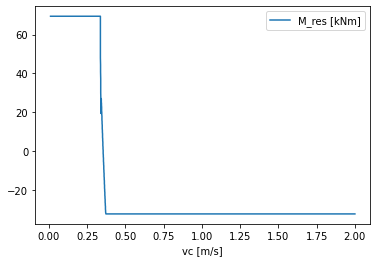

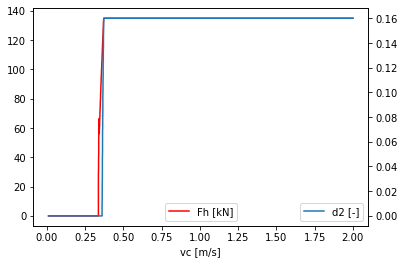

In [6]:
df.iloc[:,[0,-1]].plot(x='vc [m/s]')

fig,ax = plt.subplots()
df.iloc[:, [0,-4]].plot(x='vc [m/s]',ax=ax, color='r')
ax.legend(loc='lower center')
ax2 = ax.twinx()
df.iloc[:,[0,-5]].plot(x='vc [m/s]', ax=ax2)
ax2.legend(loc='lower right')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in true_divide
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in double_scalars


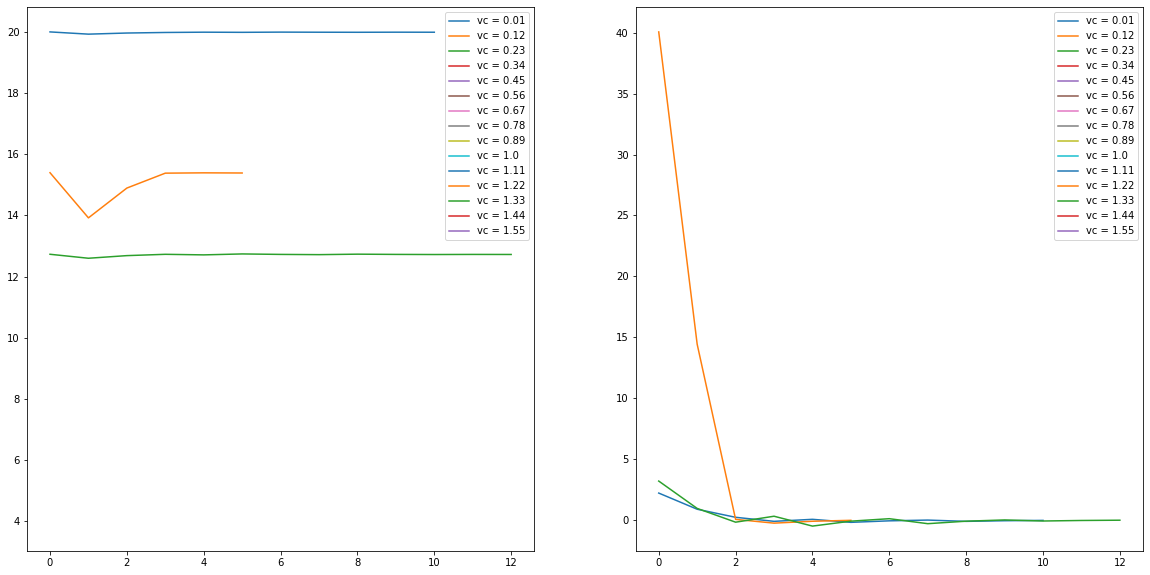

In [7]:
df = tshd.run_main_iteration(log=False, plot=True)

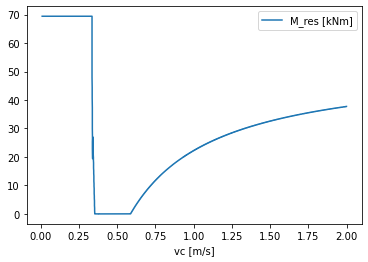

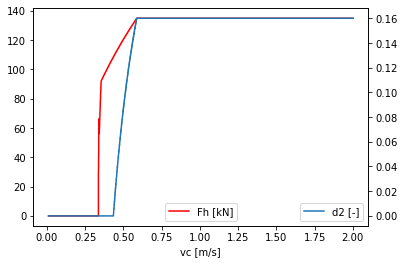

In [8]:
df.iloc[:,[0,-1]].plot(x='vc [m/s]')

fig,ax = plt.subplots()
df.iloc[:, [0,-4]].plot(x='vc [m/s]',ax=ax, color='r')
ax.legend(loc='lower center')

ax2 = ax.twinx()
df.iloc[:,[0,-5]].plot(x='vc [m/s]', ax=ax2)
ax2.legend(loc='lower right')

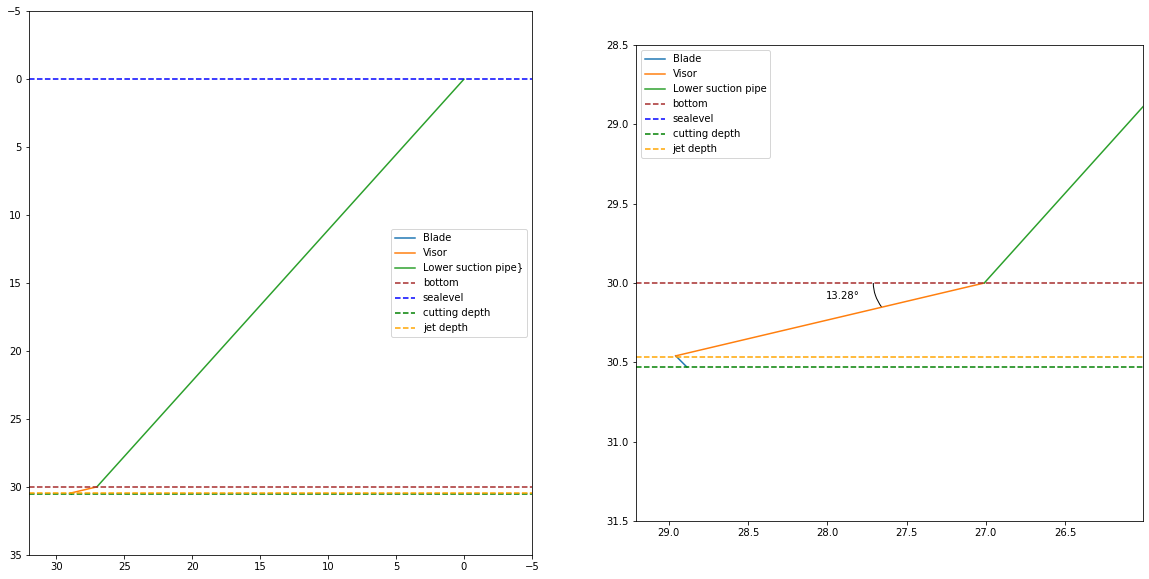

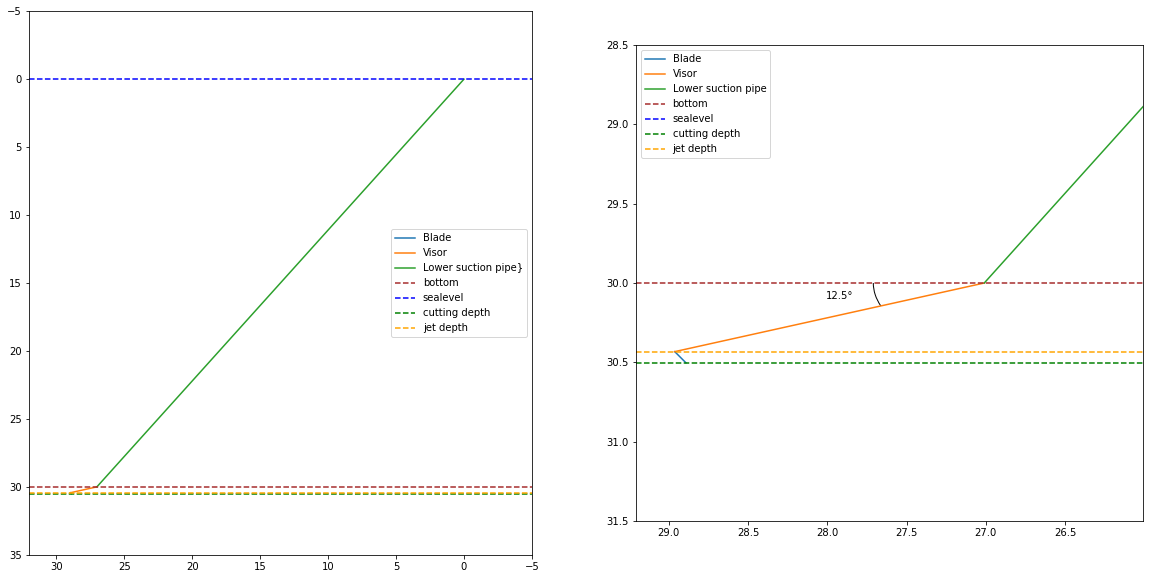

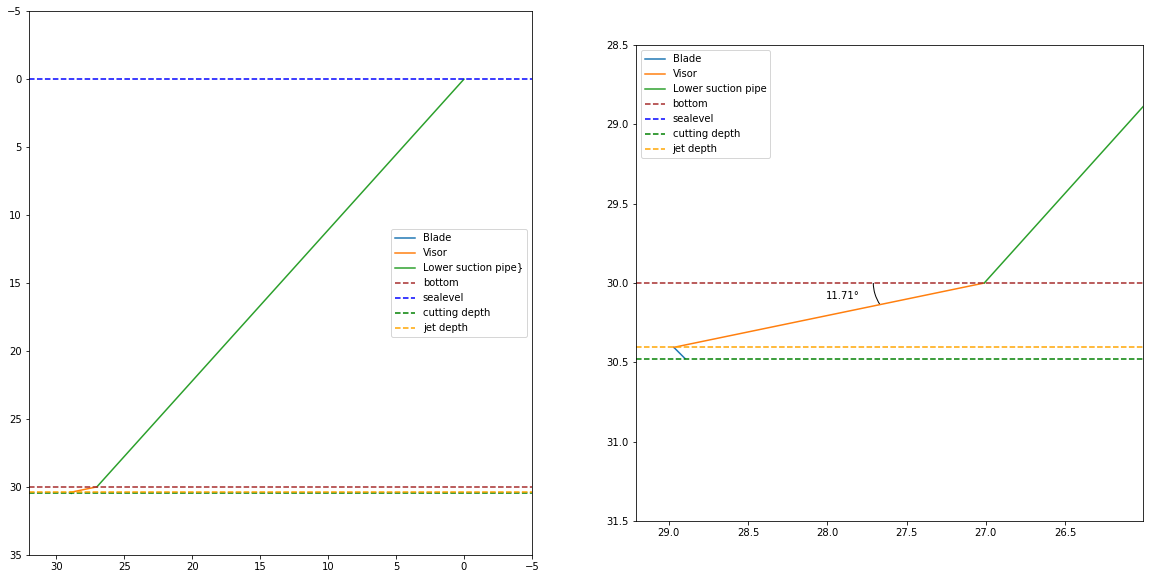

In [9]:
tshd.plot_model(tshd.breakpoint-100)
tshd.plot_model(tshd.breakpoint)
tshd.plot_model(tshd.breakpoint+100)

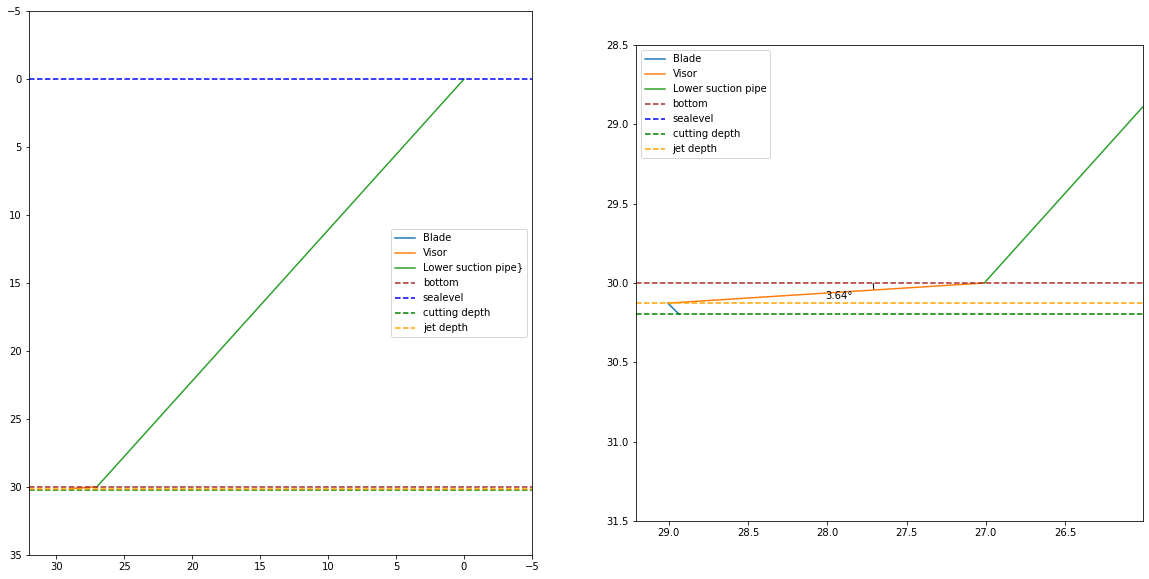

In [10]:
tshd.plot_model(-1)


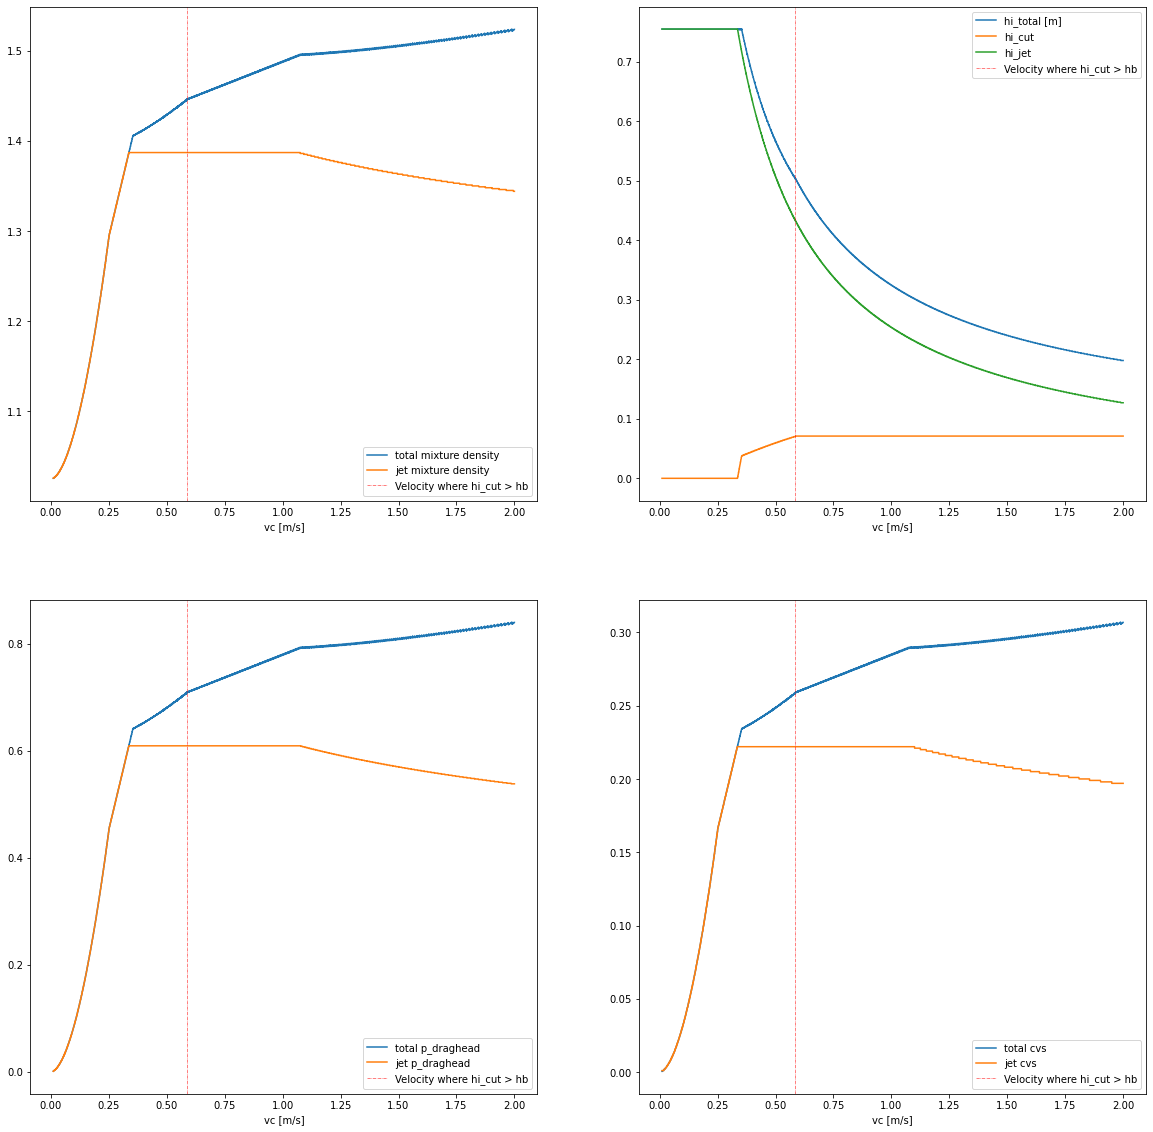

In [11]:
tshd.create_total_production_data()
tshd.plot_production_data()

Running new iteration for initial_visor_angle = 14.999999999999998


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in true_divide


Running new iteration for initial_visor_angle = 26.249999999999996


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in true_divide
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in double_scalars


Running new iteration for initial_visor_angle = 37.49999999999999


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in true_divide
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in double_scalars


Running new iteration for initial_visor_angle = 48.75


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in true_divide
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in double_scalars


Running new iteration for initial_visor_angle = 59.99999999999999


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in true_divide
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in double_scalars


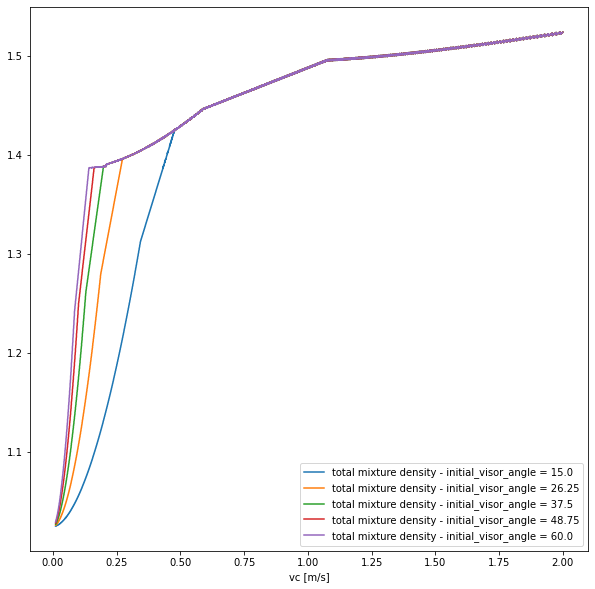

In [12]:
tshd = trailing_suction_hopper_dredger()
tshd.model_comparison('initial_visor_angle', [15*np.pi/180,60*np.pi/180], N=5)

Running new iteration for blade_angle = 35.0


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in true_divide


Running new iteration for blade_angle = 46.25


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in true_divide
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in double_scalars


Running new iteration for blade_angle = 57.49999999999999


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in true_divide
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in double_scalars


Running new iteration for blade_angle = 68.75


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in true_divide
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in double_scalars


Running new iteration for blade_angle = 80.0


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in true_divide
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in double_scalars


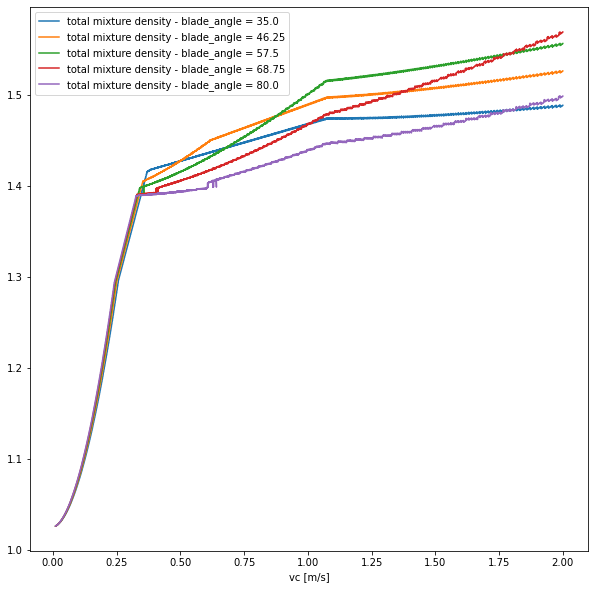

In [13]:
tshd = trailing_suction_hopper_dredger()
tshd.model_comparison('blade_angle', [35*np.pi/180, 80*np.pi/180], N=5)

Running new iteration for effective_width_power = 0.5


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in true_divide
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in double_scalars


Running new iteration for effective_width_power = 0.625


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in true_divide
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in double_scalars


Running new iteration for effective_width_power = 0.75


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in true_divide
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in double_scalars


Running new iteration for effective_width_power = 0.875


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in true_divide
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in double_scalars


Running new iteration for effective_width_power = 1.0


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in true_divide
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in double_scalars


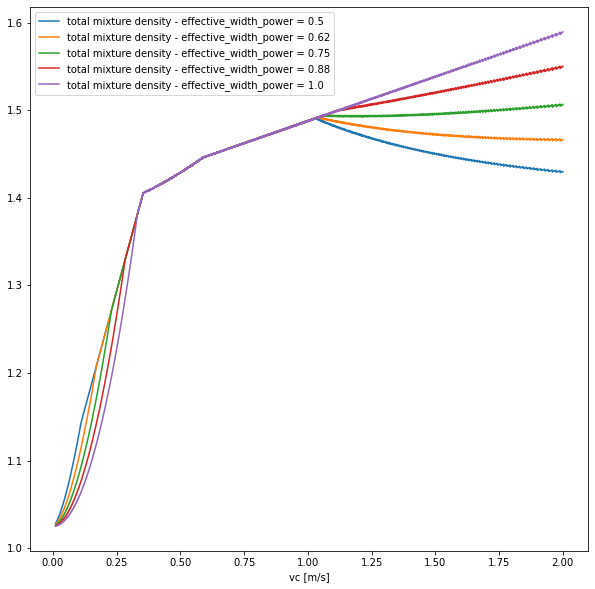

In [14]:
tshd = trailing_suction_hopper_dredger()
tshd.model_comparison('effective_width_power', [0.5, 1.0], N=5)

Running new iteration for internal_friction_angle = 25.999999999999996


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in true_divide


Running new iteration for internal_friction_angle = 30.749999999999996


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in true_divide
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in double_scalars


Running new iteration for internal_friction_angle = 35.5


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in true_divide
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in double_scalars


Running new iteration for internal_friction_angle = 40.25000000000001


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in true_divide
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in double_scalars


Running new iteration for internal_friction_angle = 45.0


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in true_divide
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in double_scalars


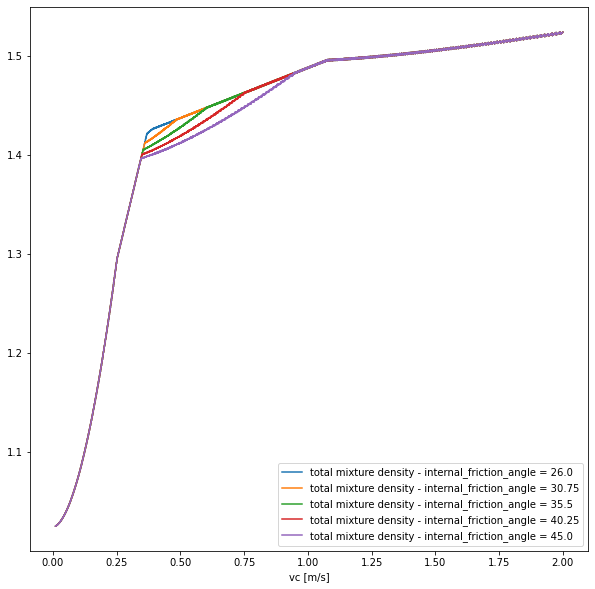

In [15]:
tshd = trailing_suction_hopper_dredger()
tshd.model_comparison('internal_friction_angle', [26/180*np.pi, 45/180*np.pi], N=5)